In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chisquare
from scipy import stats

In [2]:
stats.norm().rvs(10)

array([-1.22887268, -0.67119906,  0.64246144,  1.3052347 ,  0.42540323,
       -0.69636557, -2.03928593, -0.32186324, -1.75402974,  0.2862083 ])

### 1. Линейная зависимость

In [3]:
rng = np.random.default_rng()
#x = np.linspace(-1, 1, num=100)
x = stats.norm().rvs(100)
#y = x + 3 * rng.random(x.size)
noise  = stats.norm().rvs(x.size)
y = x + noise

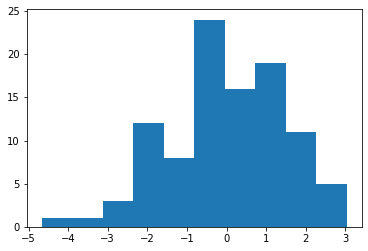

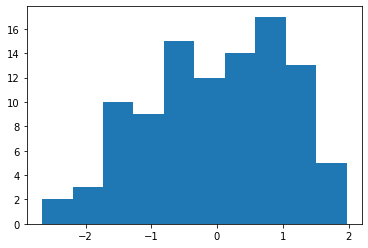

In [4]:
plt.hist(y);
plt.figure()
plt.hist(x);

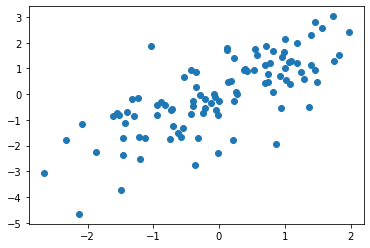

In [5]:
plt.scatter(x, y);

### 2. Монотонная нелинейная зависимость

In [6]:
rng = np.random.default_rng()
#x = np.linspace(-1, 1, num=100)
x = stats.norm().rvs(100)
#y = x + 3 * rng.random(x.size)
noise  = stats.norm().rvs(x.size)
y = x**3 + 1.2*noise

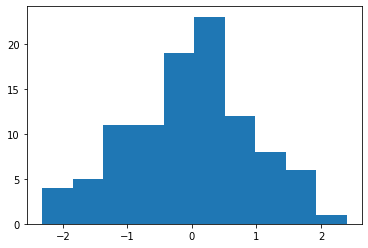

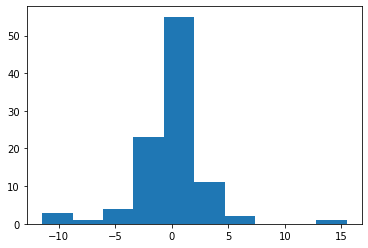

In [7]:
plt.hist(x);
plt.figure()
plt.hist(y);

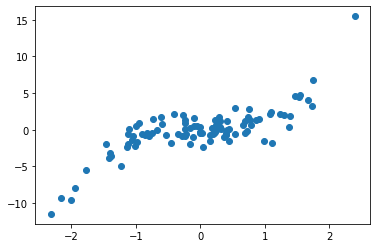

In [8]:
plt.scatter(x, y);

### 3. Немонотонная зависимость

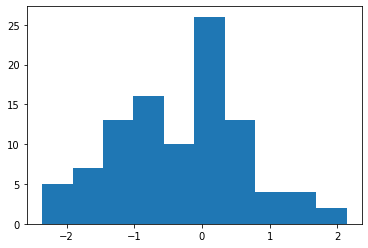

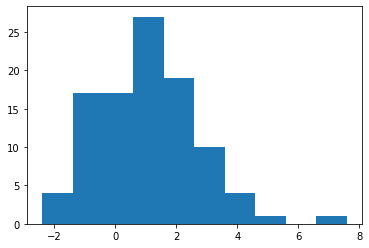

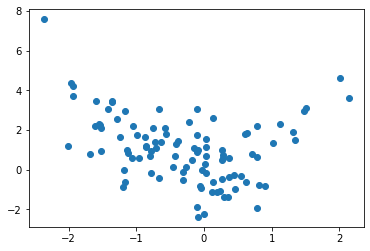

In [9]:

rng = np.random.default_rng()
x = stats.norm().rvs(100)
noise  = stats.norm().rvs(x.size)
y = x**2 + 1.2*noise
plt.hist(x);
plt.figure()
plt.hist(y);
plt.figure()
plt.scatter(x, y);

In [2]:
import pandas as pd

In [58]:
def get_nominals_features(x, y, isdraw = False):
    def mapX(x_var, x_025, x_075):
    #print('X = ',x_var)
        if x_var < x_025:
            return '1) less x_025'
        if x_var > x_075:
            return '3) more x_075'
        if (x_var >= x_025) and (x_var <= x_075):
            return '2) between x_025 and x_075'

    def mapY(y_var, y_025, y_075):
        #print('Y = ',y_var)
        if y_var < y_025:
            return '1) less y_025'
        if y_var > y_075:
            return '3) more y_075'
        if (y_var >= y_025) and (y_var <= y_075):
            return '2) between y_025 and y_075'


    df = pd.DataFrame({'X':x, 'Y':y})
    x_quant = df.X.quantile([0.25, 0.75])
    y_quant = df.Y.quantile([0.25, 0.75])
    df['Interval_X'] = df.X.apply(lambda x: mapX(x, x_quant.tolist()[0], x_quant.tolist()[1]))
    df['Interval_Y'] = df.Y.apply(lambda y: mapY(y, y_quant.tolist()[0], y_quant.tolist()[1]))
    df['Ones'] = 1

    if isdraw:
        fig, ax = plt.subplots(figsize = (7, 7))
        df[['X', 'Y']].plot.scatter(x = 'X', y = 'Y', ax = ax, label = 'Points ')
        ax.vlines(x_quant, ymin = df.Y.min(), ymax = df.Y.max(), color = 'red', label = 'X interval')
        ax.hlines(y_quant, xmin = df.X.min(), xmax = df.X.max(), color = 'blue', label = 'Y interval')
        ax.legend()
        plt.show()

    return df[['Interval_X',	'Interval_Y', 'Ones']].pivot_table(index='Interval_X', columns='Interval_Y', aggfunc='count').values

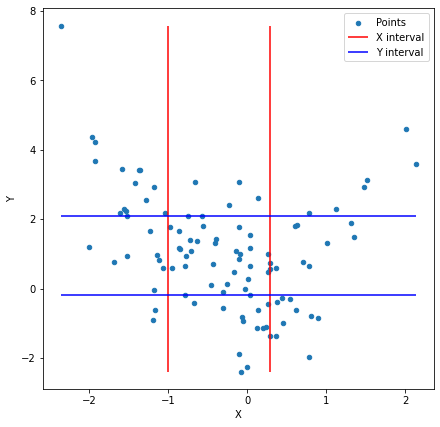

array([[ 2,  9, 14],
       [13, 32,  5],
       [10,  9,  6]], dtype=int64)

In [59]:
get_nominals_features(x, y, isdraw=True)